# ForceSMIP Example: LFCA (without training)

#### By Robb Jnglin Wills

The goal of this notebook is to demonstrate the use of low-frequency component analysis (LFCA) to estimate the forced and unforced components of climate change for a single variable, with surface air temperature used as an example, as in Wills et al. (2020, https://doi.org/10.1175/JCLI-D-19-0855.1). The basic idea of LFCA is to find the patterns that evolve the slowest within a dataset, a subset of which will be the forced response. High-frequency variability (e.g., ENSO) is filtered out. 

#### Outline:

* LFCA background
* Notes on setup with conda
* Import of key packages
* User-specified options
* Loading in the ForceSMIP data
    * Defining a function to read in data
    * Loading monthly anomaly maps for the evaluation data
    * Calculating the ensemble-mean monthly anomaly maps for the training data
* Apply LFCA to the evaluation data for specified hyperparameters

### Data structure, training and evaluation data

LFCA analyzes a data matrix with a size of the number of timesteps (n<sub>t</sub>) by the number of spatial points (n<sub>lat</sub> x n<sub>lon</sub>). The notebook is set up to use monthly surface air temperature values, though you can change the variable used or try modifying it to use annual means. 

<p align="center">
  <img width=800 src="figs/anomaly_maps.png" />
</p>

This data matrix will be created for the **training data** and the **evaluation data**. For the training data, we have many ensemble members, and we can compute the forced response as the ensemble average. For the evaluation data, we only have one realization from each model, just as we only have one realization of the real world. The challenge of ForceSMIP is to come up with methods that can approximate the forced response from these single realizations, removing internal variability as we would if we were able to take an ensemble mean.

### LFCA

The basis for LFCA is principal component analysis (aka EOF analysis). From this we find a set of basis functions (EOFs) that efficiently describe the variability in the data matrix. A key parameter in LFCA is the number of EOFs to include, which is labelled 'trucation' in the code. LFCA then looks for linear combinations of the included EOFs that maximize the ratio of low-frequency to total variance, by comparing the (principal component) amplitude of the patterns in a low-pass filtered version of the data matrix compared to their amplitude in the full data. Here, we use a 10-year (120-month) low-pass filter, but this can be modified. 

This analysis is schematically depicted below. The result are what we call low-frequency patterns (LFPs) and their low-frequency component (LFC) timeseries. 

<p align="center">
  <img width=800 src="figs/LFCA_flowchart.png" />
</p>

### Forced response estimate (LFP filtering)

To reconstruct an estimate of the forced response, we multiply LFP*LFC for a few of the leading LFP/LFC combinations to once again make a matrix with dimensions of the number of timesteps (n<sub>t</sub>) by the number of spatial points (n<sub>lat</sub> x n<sub>lon</sub>). Wills et al. (2020) calls this LFP filtering. The number of LFP/LFC combinations to include, which is called `N_LFCs` in the code, is the other key hyperparameter of the analysis.

### Utilizing the training data (only in ForceSMIP_LFCA.ipynb, skipped for this simple notebook)

The training data is used for choosing the hyperparamters `trucation` and `N_LFCs`. Here, the notebook simply tries a few different values of each, then compares the LFP filtered forced reponse estimate to the "right answer", which for the case of the training data is the ensemble mean. This notebook shows a few different possible skill estimates, and the user is free to choose which values work best for their needs depending on what they want to optimize, i.e., anomaly correlation coefficient (ACC) vs. root-mean square error (RMSE), spatial pattern of trends vs. spatiotemporal variance at monthly timescales. 

## Some setup notes

If you are using Jupyter (or Python with conda environments), there may be a `forcesmip` kernel/environment pre-installed for you to use. You can also check by clicking `Kernel` > `Change Kernel...` (and then look for a `forcesmip` kernel). You can determine if a conda environment exists by looking for it with `conda info --envs` in a terminal. If you use a pre-installed kernel, you can simply use the pre-installed `forcesmip` kernel and you do not need to continue with this setup.

This setup assumes that you have anaconda installed. If you do not, you can install miniconda (from [here](https://docs.conda.io/en/main/miniconda.html)). On some systems you may need to load or activate conda (e.g., via `module load conda` on NCAR systems). Once conda is installed and active, you can create a forcesmip environment with (the `-y` flag create the environment without a confirmation prompt): 

`conda create -n forcesmip -c conda-forge xcdat xesmf scikit-learn scipy eofs matplotlib cartopy nc-time-axis ipython ipykernel tensorflow python=3.9 -y`

> NOTE: This may take a long time (i.e., hours!). If you're in a rush and are not using neural networks, you can remove `tensorflow` from `conda install` and install it afterwards with `pip install tensorflow` (if desired). 

Activate your environment with: `conda activate forcesmip` or `source activate forcesmip`

If you'd like to be able to use this environment with Jupyter, you need to install it with:

`python -m ipykernel install --user --name forcesmip --display-name forcesmip`

### Import packages (code starts here)

In [1]:
# I/O / data wrangling
import os
import glob
import re
import numpy as np
import xarray as xr
import xcdat as xc

# data analysis
from eofs.standard import Eof
from scipy.signal import convolve, butter, filtfilt

# runtime metrics
import time as clocktime

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

### Define LFCA, Eigenvalue Analysis, and helper functions

Look under the hood. Here are the functions needed for LFCA. 

Note that this is currently setup to use numpy. There is an option to switch it to xarray, which is more efficient, but it requires fixing a bug in the installed eofs package: https://stackoverflow.com/questions/71740621/eofs-xarray-raising-typeerror-using-a-dataarray-to-construct-a-variable-is-ambi. 

In [2]:
"""
New xarray implementation of Low-Frequency Component Analysis (LFCA)

Author: Oliver Mehling (University of Torino)
Based on Numpy Version by: Zhaoyi Shen (Caltech)
Minor edits by: Robb Jnglin Wills (ETH Zurich)

Reference:  Wills et al.: Disentangling Global Warming, Multidecadal Variability,
            and El Niño in Pacific Temperatures,
            Geophysical Research Letters 45, 2487-2496 (2018)
"""
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from eofs.standard import Eof
from scipy.signal import convolve, butter, filtfilt

### Helper functions ###
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.
        
    References
    ----------
        from https://scitools.org.uk/iris/docs/v1.2/examples/graphics/SOI_filtering.html

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def filter_padding(ts, window, ftype='mirror', detrend=True, detrend_poly=1): 
    ts_pad = np.zeros(2*window+len(ts))
    if detrend:
        t = np.arange(len(ts))
        z = np.polyfit(t,ts,detrend_poly)
        p = np.poly1d(z)
        ts_in = ts-p(t)
    else:
        ts_in = ts
    ts_pad[window:-window] = ts_in[:]
    if ftype == 'mirror':
        ts_pad[:window] = ts_in[:window][::-1]
        ts_pad[-window:] = ts_in[-window:][::-1]
    elif ftype == 'periodic':
        ts_pad[:window] = ts_in[-window:]
        ts_pad[-window:] = ts_in[:window]
    else:
        raise ValueError('in filter_padding: ftype must be one of "mirror" or "periodic".')
    if detrend:
        t_pad = np.arange(-window,len(ts)+window)
        ts_pad = ts_pad+p(t_pad)
    return ts_pad

def filter_ts(ts, cutoff, filter_type='lanczos', padding_type='mirror', detrend=True, detrend_poly=1): 
    lanczos_weights=low_pass_weights(cutoff*2+1,1./cutoff) # weights for Lanczos filter
    n_pad=int(np.ceil(len(lanczos_weights)/2))
    
    # Padding
    ts_mirr=filter_padding(ts,n_pad,padding_type,detrend=detrend,detrend_poly=detrend_poly)
    
    # Filtering
    if filter_type=='lanczos':
        # Lanczos filter
        return convolve(ts_mirr,lanczos_weights,'same')[n_pad:-n_pad]
    elif filter_type=='butter':
        # Butterworth filter
        # TODO: here, the cutoff frequency needs to be doubled
        # to obtain the same result as for Lanczos - why?
        b,a = butter(3,1./(cutoff/2),btype='low')
        return filtfilt(b,a,ts_mirr)[n_pad:-n_pad]
    else:
        raise ValueError('in filter_ts: filter_type must be one of "lanczos" or "butter".')
        
### Main LFCA function ###
def lfca(x, cutoff, truncation, weights, **kwargs):
    if x.ndim!=2:
        raise ValueError('x must have dimension 2 for LFCA')
    
    # Scale vector from weights
    scale = np.sqrt(np.transpose(weights)/np.sum(weights))
    
    # center data
    x = x - np.mean(x,axis=0)
    xs = x * scale.T
    
    # Compute EOFs using eofs package
    # xarray version: eofs_xr=Eof(xs, center=False, ddof=1)
    eofs_xr=Eof(xs.values, center=False, ddof=1)
    # Principal component time series (PC_k)
    pcs=eofs_xr.pcs(npcs=truncation, pcscaling=1)
    
    # Filtering of PCs
    pcs_filt=np.zeros(pcs.shape)
    for i in range(truncation):
        pci = pcs[:,i]
        pci_filt = filter_ts(pci, cutoff, **kwargs)
        pcs_filt[:,i]=pci_filt[:]
        #print(np.std(pci),np.std(pci_filt))
    
    # Compute low-frequency components
    cov_lowfreq=np.cov(pcs_filt,rowvar=False)
    eig_lowfreq, eigv_lowfreq = np.linalg.eigh(cov_lowfreq) # Eigenvalues r_k, Eigenvectors e_k
    eig_argsort = np.argsort(eig_lowfreq)[::-1].copy() # Guarantee that eigenvalues are sorted in descending order
    eig_lowfreq = eig_lowfreq[eig_argsort].copy()
    eigv_lowfreq = eigv_lowfreq[:,eig_argsort].copy()

    uvec=eofs_xr.eofs(neofs=truncation, eofscaling=1).T@eigv_lowfreq # u_k
    # xarray version: lfcs=xs@uvec # Low-frequency components (LFC_k)
    lfcs = np.dot(xs, uvec)
    lfps=eofs_xr.eofs(neofs=truncation, eofscaling=2).T@eigv_lowfreq # v_k = Low-frequency patterns (LFP_k)
    # NB: Alternative formula (lfps=xs.T@lfcs) gives the right pattern, but wrong scaling
    
    # Choose positive sign of LFCs/LFPs
    for j in range(lfps.shape[1]):
        if np.dot(lfps[:,j], scale.flatten())<0:
            lfps[:,j] = -lfps[:,j]
            lfcs[:,j] = -lfcs[:,j]
    lfps=lfps/scale # Re-scale LFPs (non-weighted)
    lfps = np.transpose(lfps)
    
    return lfcs, lfps

### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [3]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [4]:
root_dir = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/"  # path to forcesmip data (ETH)
#root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # path to forcesmip data (NCAR)

outdir = "data/"  # directory where output data should be saved

ncvar = "tos"  # CMIP variable name to be used

cutoff = 120 # months (lowpass cutoff) - you can also try varying this parameter
truncation = 30 # EOF truncation
N_LFC = 2 # how many LFCs to include in the forced response

# choose models for training
# this version of the LFCA code skips the training. See ForceSMIP_LFCA.ipynb for an idea of how to train the method 
# (to select the values of truncation and N_LFC that work best)

# choose evaluation data
eval_tier = "Tier2"  # Tier1, Tier2, or Tier3

# no need to modify the training or reference period for LFCA
tv_time_period = evalPeriods[eval_tier] # ("1950-01-01","2022-12-30")  # period of time to consider data for training
reference_period = tv_time_period # anomalies will be with respect to mean over entire period (convectional for LFCA)

### Define a function to read in data

We're going to loop over many models and realizations for training and evaluation data. To make this more readable and to reduce repeating code, we are going to define a function to do this operation.

In [5]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the anomalies
    relative to a user-defined reference_period. The function returns arrays
    of the dimensions (time, lat, lon), the 3D anomaly map, and the global
    mean time series. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : monthly average anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : monthly average, global mean anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # If you wanted annual averages instead, you could use the following:
    # ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # take spatial average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    # return values
    return ts_3d, ts_gm

### Read in evaluation data

We start with the evaluation data, because this data includes observations...and missing data. We will load the evaluation data and create a missing data mask, which we will apply to the training/evaluation data as well. That way the training and evaluation data will be consistent.

In [6]:
# first we search for the evaluation data
epath = "/".join([root_dir, "Evaluation-" + eval_tier, cmipTable[ncvar], ncvar])
efiles = glob.glob(epath + "/*.nc")
efiles = sorted(efiles, key=natsort)

# initialize dictionary to store data
evaluation_anomaly_maps = {}
missing_data_mask = {}
vid = cmipVar[ncvar]

# loop over evaluation files
for im, fn in enumerate(efiles):
    # get evaluation identifier
    model = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + model)
    # read in data for realization
    ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
    # store anomaly map
    evaluation_anomaly_maps[model] = ts_3d
    
    # create mask for missing data
    tmp = np.mean(ts_3d, axis=0)
    missing_data_mask[model] = np.where(np.isnan(tmp), np.nan, 1)

1 / 10: 2A
2 / 10: 2B
3 / 10: 2C
4 / 10: 2D
5 / 10: 2E
6 / 10: 2F
7 / 10: 2G
8 / 10: 2H
9 / 10: 2I
10 / 10: 2J


## LFCA of evaluation members

Now that we have undergone the time intensive task of training, we can choose values of 'truncation' and 'N_EOFs' based on the above plots (there is no right way to do this), apply LFCA to the evalution members, and visualize the results. 

In [7]:
# initialize dictionaries for LFCA output
lfcs_eval_all = {}
lfps_eval_all = {}
X_forced_eval_all = {}
X_total_eval_all = {}

eval_models = evaluation_anomaly_maps.keys()

for ie, eval_model in enumerate(eval_models):
    
    print("Model " + eval_model)
    
    # convert missing data mask from nans to zeros
    mask = np.nan_to_num(missing_data_mask[eval_model], nan=0)
    
    lfcs_eval_all[eval_model] = {}
    lfps_eval_all[eval_model] = {}
    X_forced_eval_all[eval_model] = {}
    X_total_eval_all[eval_model] = {}
    
    # this is the data from each training model/member
    sst_anomalies = evaluation_anomaly_maps[eval_model]

    # extract coordinate vectors (same for all models, so could be moved out of the loop)
    lon_axis = evaluation_anomaly_maps[eval_model].lon
    lat_axis = evaluation_anomaly_maps[eval_model].lat
    time = evaluation_anomaly_maps[eval_model].time
    # dimensions of the data matrix
    n_timesteps = len(time)
    nfeatures = nlat * nlon
    
    # create cos(lat) weighting, with mask for missing data 
    y, x = np.meshgrid(lat_axis,lon_axis)
    area = np.cos(y*np.pi/180.) * np.transpose(mask)
    area_weights = np.reshape(area,(nfeatures,1),order='F')

    # combine lat & lon into a single spatial dimension
    x_all = sst_anomalies.stack(shape=['lat','lon'])

    # these give the spatial points (columns) where there are not and are missing data, in icol_ret and icol_disc, respectively
    icol_ret = np.where(area_weights!=0)
    icol_disc = np.where(area_weights==0)
    # remove missing spatial points from x and area_weights
    x = x_all[:,icol_ret[0]]
    area_weights = np.transpose(area_weights[icol_ret[0],:])

    # perform LFCA for each evaluation model 
    lfcs, lfps =  lfca(x, cutoff, truncation, area_weights)

    # put back in missing data 
    nins = len(icol_disc[0])
    nrows = lfps.shape[0]
    lfps_aug = np.zeros((nrows,lfps.shape[1]+nins))
    lfps_aug[:] = np.nan
    lfps_aug[:,icol_ret[0]] = lfps
    
    # time axis
    time_plot = [t.year + t.month/12 for t in time.values]
    
    # forced response estimate from LFP filtering
    X_forced = np.matmul(lfcs[:,0:N_LFC],lfps_aug[0:N_LFC,:])
    X_forced = X_forced.reshape(n_timesteps,nlat,nlon)
    X_forced = xr.DataArray(X_forced, coords=[time_plot,lat_axis,lon_axis], dims=["time","lat","lon"])
    
    # put output in library
    lfcs_eval_all[eval_model] = lfcs
    lfps_eval_all[eval_model] = lfps_aug
    X_forced_eval_all[eval_model] = X_forced
    X_total_eval_all[eval_model] = sst_anomalies

Model 2A
Model 2B
Model 2C
Model 2D
Model 2E
Model 2F
Model 2G
Model 2H
Model 2I
Model 2J


## Plot the first four LFPs and LFCs for an evaluation member of choice

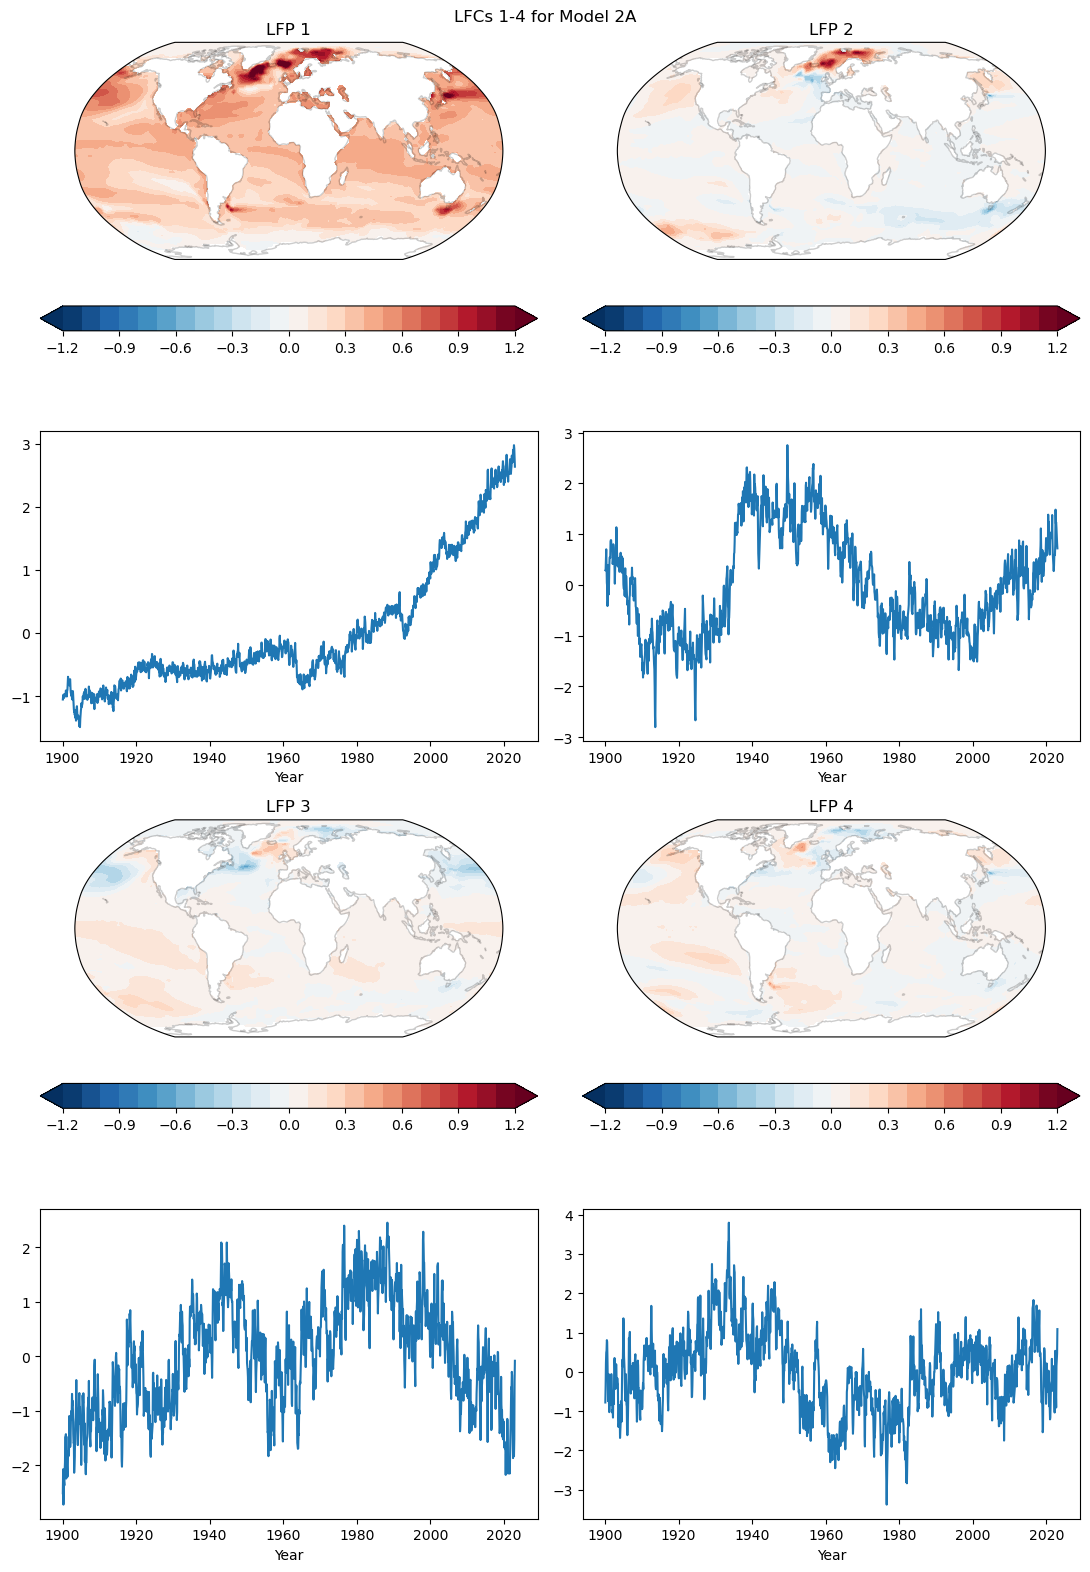

In [8]:
plot_model = '2A'

clev = np.arange(-1.2, 1.3, 0.1)
#clev = np.arange(-200, 205, 5)

lfcs = lfcs_eval_all[plot_model]
lfps_aug = lfps_eval_all[plot_model]

LFCs_plot = (1,2,3,4)

f=plt.figure(figsize=(11, 16))
for i in range(0,4):
    pattern = np.reshape(lfps_aug[i,...],(nlon,nlat),order='F')
    pattern[np.where(np.abs(pattern)>1.e5)] = np.nan
    if i>1:
        plt.subplot(4, 2, i+3, projection=ccrs.Robinson())
    else:
        plt.subplot(4, 2, i+1, projection=ccrs.Robinson())
    map_plot = np.transpose(pattern)
    cyclic_data, cyclic_longitude = add_cyclic_point(map_plot, coord=lon_axis)
    im = plt.contourf(cyclic_longitude, lat_axis, cyclic_data, clev, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    # colorbar
    plt.colorbar(orientation='horizontal')
    plt.title('LFP '+str(i+1))
    if i>1:
        plt.subplot(4, 2, i+5)
    else:
        plt.subplot(4, 2, i+3)
    plt.plot(time_plot,lfcs[:,i])
    plt.xlabel("Year")
    
plt.suptitle('LFCs 1-4 for Model '+plot_model)
plt.tight_layout()

## LFP filtered trends over the full time period (based on chosen tier)

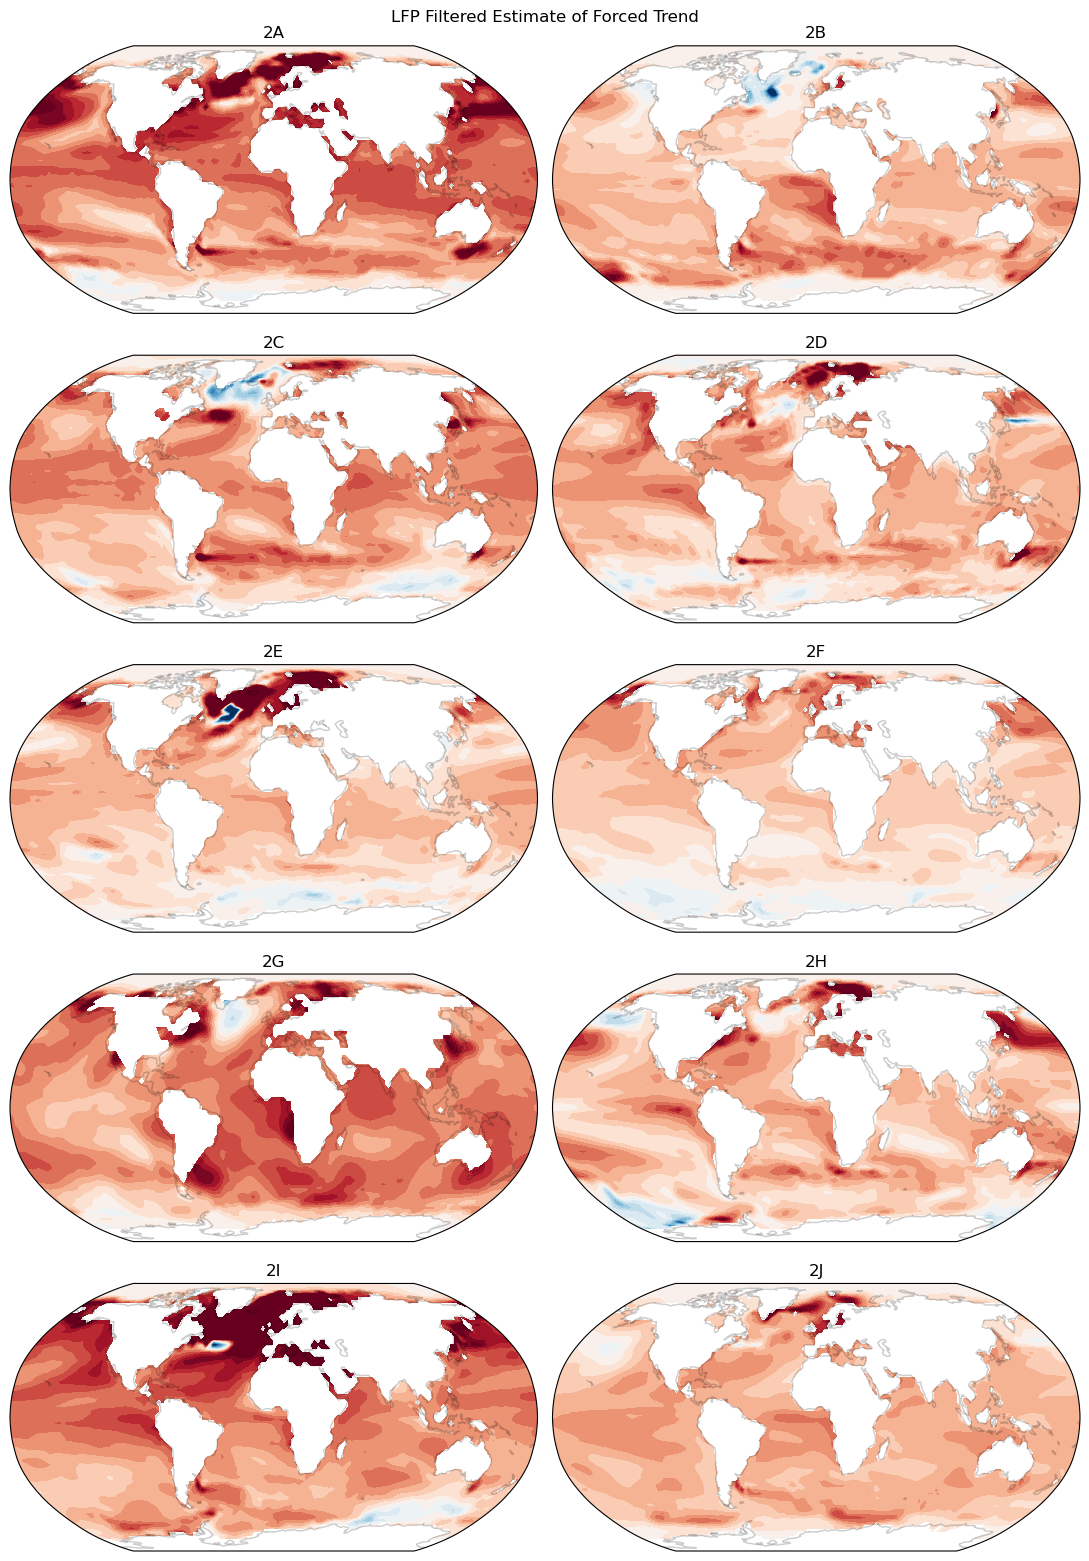

In [9]:
clevs = np.arange(-2, 2.2, 0.2)
#clevs = np.arange(-400, 405, 5)

f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1, projection=ccrs.Robinson())
    X_forced = X_forced_eval_all[eval_model]
    X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients
    map_plot = X_forced_trend.values*(time_plot[-1]-time_plot[0])
    cyclic_data, cyclic_longitude = add_cyclic_point(map_plot, coord=lon_axis)
    im = plt.contourf(cyclic_longitude, lat_axis, cyclic_data, clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(eval_model)
plt.suptitle('LFP Filtered Estimate of Forced Trend')
plt.tight_layout()

## Visualizing LFP Filtering for Global Mean

The real benefits of LFCA aren't necessarily for the trend pattern over the full time period but in getting information about how this forced response pattern evolves in time (i.e., the full spatiotemporal complexity of the forced response). We visualize what LFP filtering is doing to the raw data for the global mean and a few other specific timeseries

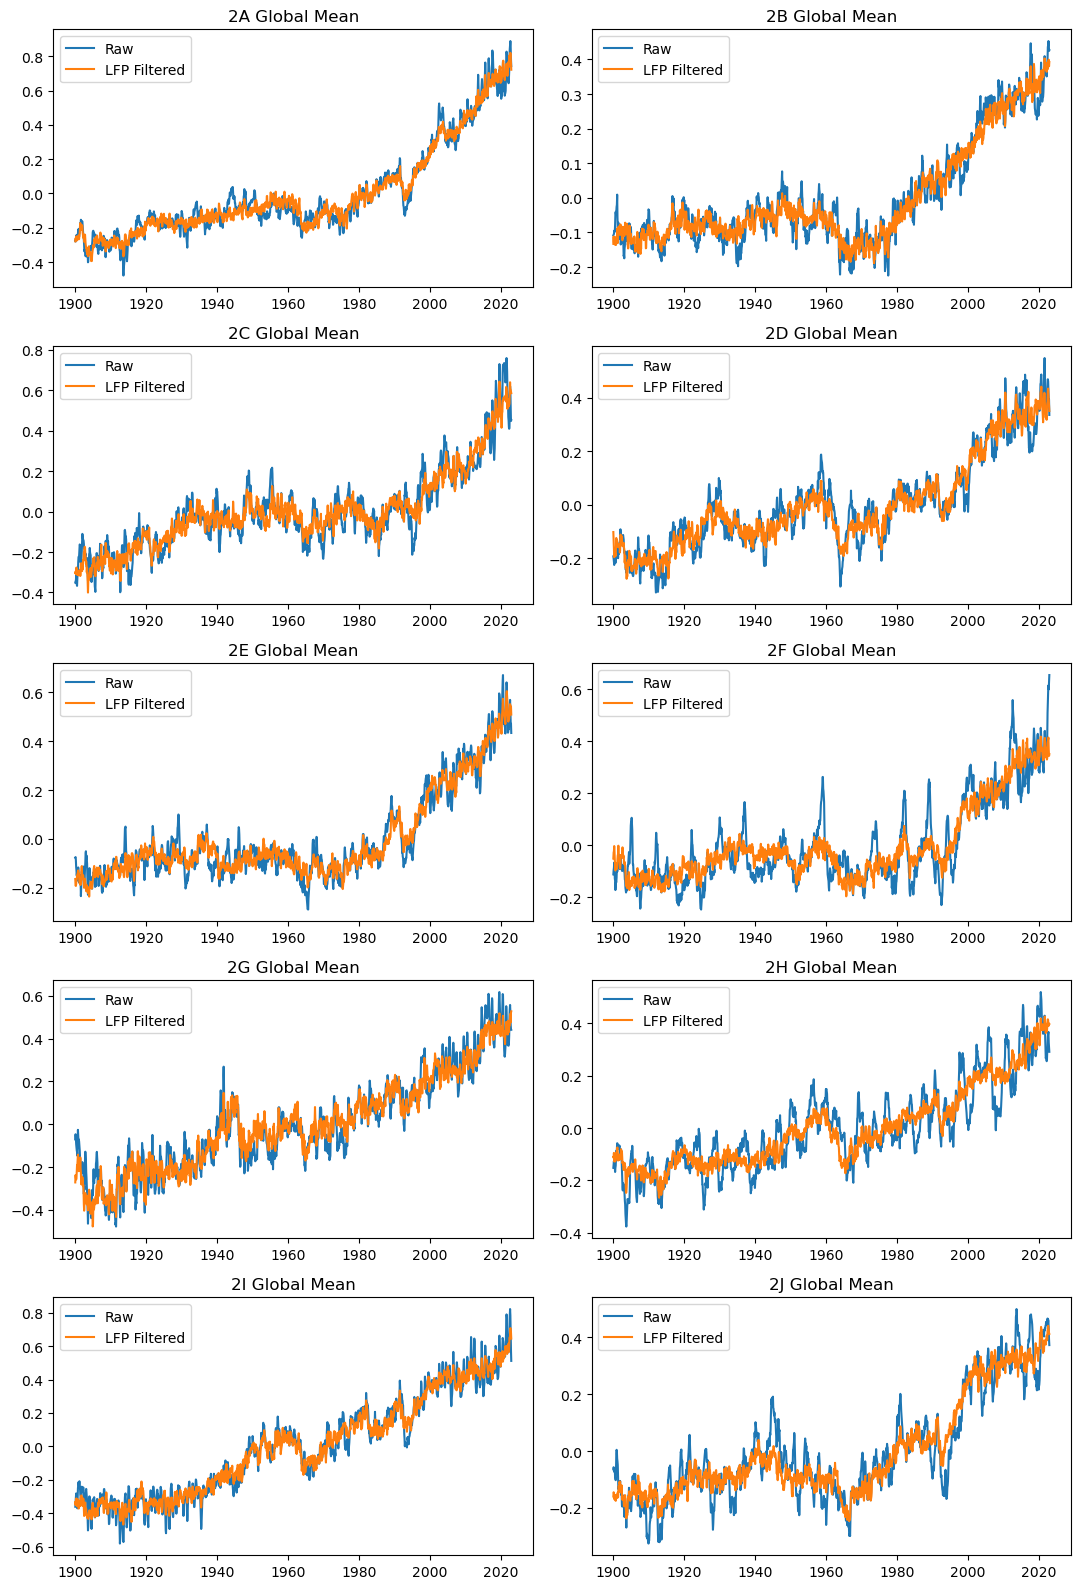

In [10]:
time_plot = [t.year + t.month/12 for t in time.values]
cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1)
    X_forced = X_forced_eval_all[eval_model]
    X_total = X_total_eval_all[eval_model]
    GMST_total = (X_total*cosw).mean('lon').mean('lat')
    GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
    plt.plot(time_plot,GMST_total)
    plt.plot(time_plot,GMST_forced)
    plt.title(eval_model+' Global Mean')
    plt.legend(['Raw','LFP Filtered'])
plt.tight_layout()

## And the same visualization for Niño3.4 region

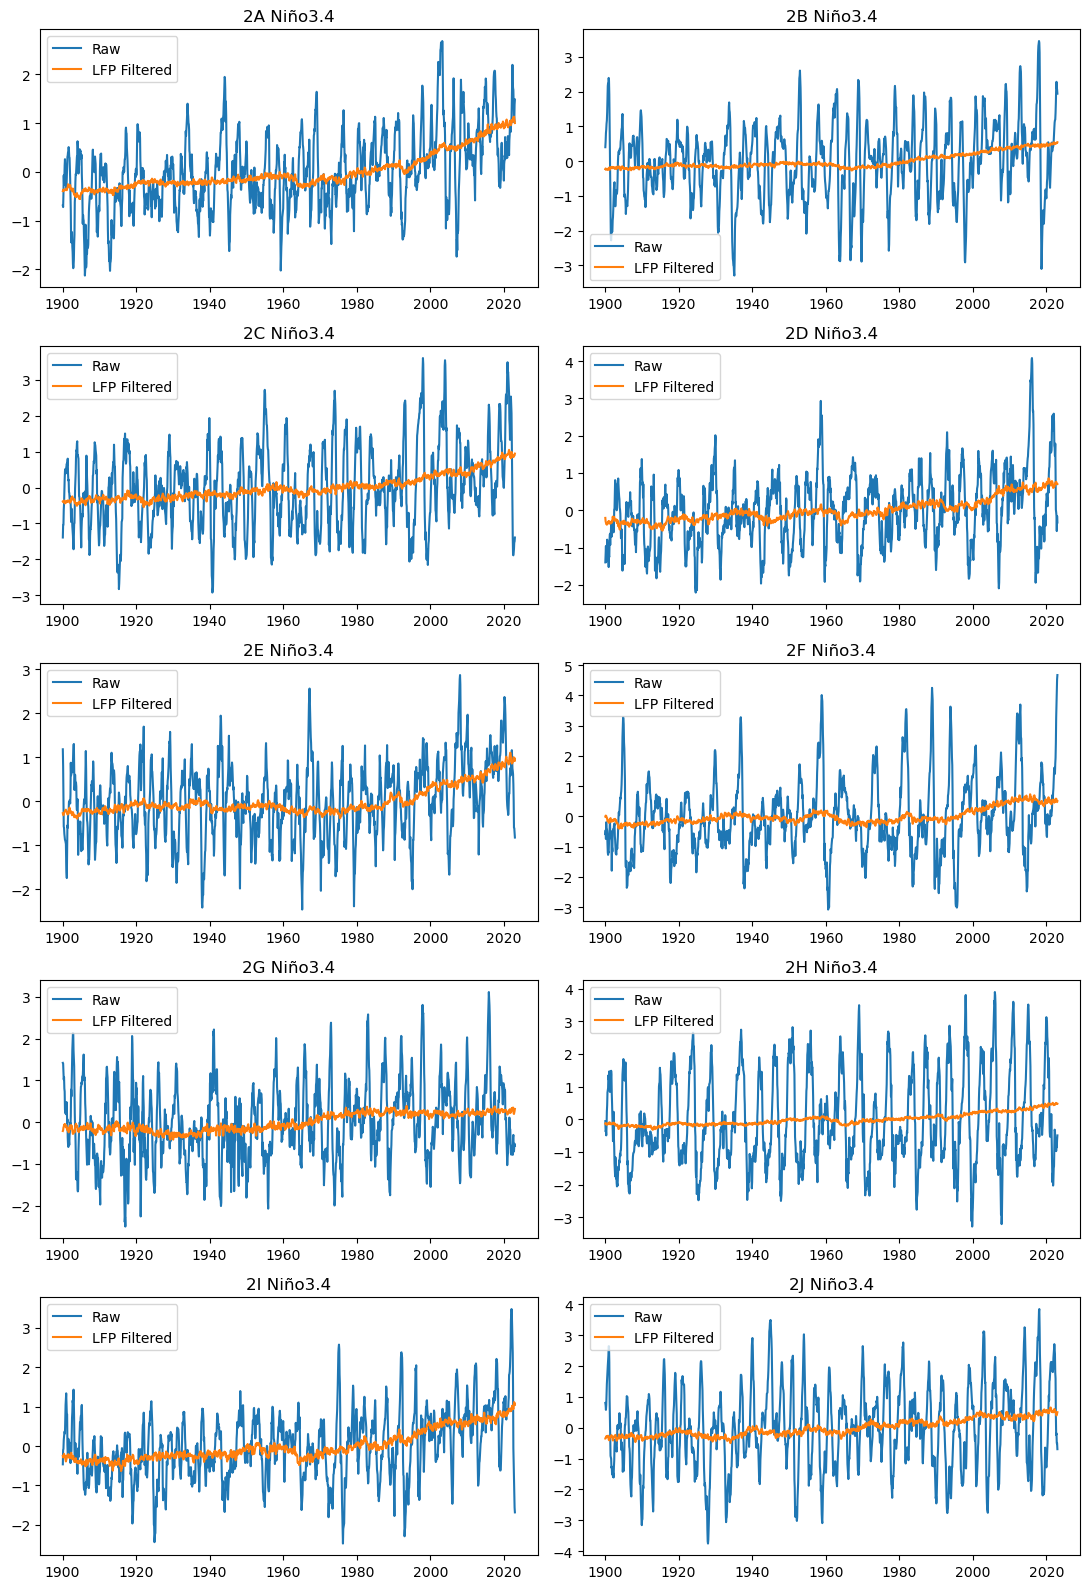

In [11]:
time_plot = [t.year + t.month/12 for t in time.values]
cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
f = plt.figure(figsize=(11, 16))
for ie, eval_model in enumerate(eval_models):
    plt.subplot(5, 2, ie+1)
    X_forced = X_forced_eval_all[eval_model]
    X_total = X_total_eval_all[eval_model]
    Nino34_forced = (X_forced*cosw).sel(lon=slice(190,240),lat=slice(-5,5)).mean('lon').mean('lat')
    Nino34_total = (X_total*cosw).sel(lon=slice(190,240),lat=slice(-5,5)).mean('lon').mean('lat')
    # if you want to compute the global mean and subtract that from Nino34:
    #GMST_total = (X_total*cosw).mean('lon').mean('lat')
    #GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
    plt.plot(time_plot,Nino34_total)
    plt.plot(time_plot,Nino34_forced)
    plt.title(eval_model+' Niño3.4')
    plt.legend(['Raw','LFP Filtered'])
plt.tight_layout()

## And the same visualization for the grid cell corresponding to Boulder or Zurich

In [12]:
location = 'Zurich'

if ncvar == "tos":
    print('Skipping plot for ocean variable')
else:
    if location == 'Zurich':
        sel_lat = 47.4 # closest to 47.4°N
        sel_lon = 8.5 # closest to 8.5°E
    elif ftype == 'Boulder':
        sel_lat = 40.02 # closest to 40.02°N
        sel_lon = 254.7 #closest to 105.3°W
    else:
        raise ValueError('Only has options for Zurich and Boulder.')

    time_plot = [t.year + t.month/12 for t in time.values]
    cosw = np.sqrt(np.cos(lat_axis*np.pi/180))
    f = plt.figure(figsize=(11, 16))
    for ie, eval_model in enumerate(eval_models):
        plt.subplot(5, 2, ie+1)
        X_forced = X_forced_eval_all[eval_model]
        X_total = X_total_eval_all[eval_model]
        Nino34_forced = (X_forced).sel(lon=8.75, lat=47.4, method='nearest')
        Nino34_total = (X_total).sel(lon=8.75, lat=47.4, method='nearest')
        # if you want to compute the global mean and subtract that from Nino34:
        #GMST_total = (X_total*cosw).mean('lon').mean('lat')
        #GMST_forced = (X_forced*cosw).mean('lon').mean('lat')
        plt.plot(time_plot,Nino34_total)
        plt.plot(time_plot,Nino34_forced)
        plt.title(eval_model+' '+location)
        plt.legend(['Raw','LFP Filtered'])
    plt.tight_layout()

Skipping plot for ocean variable


### Discussion Questions

* How would you choose between optimizing the skill metrics presented? Can you think of other skill metrics to use?
* We've evaluated the monthly variability and the full-period trend. How about timescales in between (e.g., annual means, 5-year means)? 
* Do you think this approach (LFCA) would work well for other variables of interest?

### NetCDF Output of Forced Response Estimate

In [13]:
eval_model = "2H"
name = "LFCA.Wills"

# ensure directory exists to write out data
if not os.path.exists('data/'):
    os.mkdir(outdir)
    
filename = outdir+eval_model+"."+ncvar+"."+name+".nc"

X_forced = X_forced_eval_all[eval_model]
X_forced_trend = X_forced.polyfit('time',1).isel(degree=0).polyfit_coefficients*np.ceil(time_plot[-1]-time_plot[0])
X_forced_trend = X_forced_trend.rename("forced_component")

print ('saving to ', filename)
X_forced_trend.to_netcdf(path=filename)
X_forced_trend.close()
print ('finished saving')

saving to  data/2H.tos.LFCA.Wills.nc
finished saving
